# aws-smsl-predict-airquality-via-weather
A Jupyter Notebook that connects to Amazon Sustainability Data Initiative (ASDI) datasets from NOAA and OpenAQ to build a Machine Learning (ML) model to predict air quality via weather.

## PROBLEM: 1 out of 8 deaths in the world is due to poor air quality (source: OpenAQ.org)
This notebook explores correlations between weather and air quality since we know factors like temperatures, wind speeds, etc, affect certain air quality parameters. Predicting air quality based on weather can get into highly sophisticated ML techniques, but this demo shows how merging NOAA GSOD weather data with OpenAQ air quality data to build an ML model using AutoGluon (AutoML from AWS) can result in prediction accuracy of ~75-85% using Binary Classification models for the Los Angeles, CA, and Las Vegas, NV areas for a target parameter of 2.5 micron Particulate Matter (PM2.5).

## INSTRUCTIONS
- Configure your environment using the environment.yml file or by running the *pip install* commands below.
- CELL #3: Review the Variables and Classes defined in this cell to see defaults and how ASDI access occurs.
- CELL #4: Review the defined AQParams and Scenarios in this cell. You can edit these and/or use your own.
- CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process.
- Step through the remaining cells in the Notebook to access data, merge data, and build a Binary Classification Autogluon model.

In [1]:
# Set up your environment according to the environment.yml file or run the following...
# %pip install boto3
# %pip install pandas
# %pip install numpy
# %pip install requests
# %pip install ipywidgets
# %pip install scikit-learn
# %pip install autogluon

In [2]:
# Import statements for packages used...
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import requests
import urllib
import json
import ipywidgets as widgets

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from datetime import datetime
from types import SimpleNamespace

In [3]:
# CELL #3: Review the Variables and Classes defined in this cell to see defaults and how ASDI access occurs...
# Define some Variables and Classes to make life easier.
yearStart       = 2016                  # This is about as early as OpenAQ data begins
yearEnd         = datetime.today().year # Get as much data as possible
mlTargetLabel   = 'isUnhealthy'         # Makes for easy + consistent reference to our target label
mlEvalMetric    = 'accuracy'            # Binary Classification evaluation metric to best fit
mlTimeLimitSecs = None                  # Autogluon time_limit in seconds, eg: 60*5 = 300 => 5mins; None => Use Default
mlIgnoreColumns = ['DATE','NAME','LATITUDE','LONGITUDE','day','unit','average','parameter'] # Not relevant as features for training/fit
defaultColumnsNOAA   = ['DATE','NAME','LATITUDE','LONGITUDE',
                        'DEWP','WDSP','MAX','MIN','PRCP','DAYOFWEEK','MONTH']               # Default relevant NOAA columns
defaultColumnsOpenAQ = ['day','parameter','unit','average']                                 # Default relevant OpenAQ columns
aqParams    = {}
aqScenarios = {}

# class AQParam => Defines the main six OpenAQ parameters with default unHealthyThreshold values.
class AQParam:
    aqKeyColumns  = defaultColumnsOpenAQ
    def __init__(self, id, name, unit, unhealthyThreshold, desc, aqKeyColumnsOverride=None):
        self.id                 = id
        self.name               = name
        self.unit               = unit
        self.unhealthyThreshold = unhealthyThreshold
        self.desc               = desc
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=2)

# class Scenario => Defines an ML scenario including a Location that includes a NOAA Weather Station ID and the target OpenAQ Param.
class Scenario:
    targetLabel     = mlTargetLabel
    noaaKeyColumns  = defaultColumnsNOAA
    noaaStationLat  = 0.0
    noaaStationLng  = 0.0
    openAqLocIDs    = []
    localDataNOAA   = ""
    localDataOpenAQ = ""
    
    def __init__(self, name, yearStart, yearEnd, aqParamTarget, aqRadiusMiles, noaaStationID, noaaKeyColumnsOverride=None, unhealthyThresholdOverride=None):
        self.name               = name
        self.yearStart          = yearStart
        self.yearEnd            = yearEnd
        self.aqParamTarget      = aqParamTarget
        self.aqRadiusMiles      = aqRadiusMiles
        self.aqRadiusMeters     = aqRadiusMiles * 1610 # Rough integer approximation is fine here.
        self.noaaStationID      = noaaStationID
        self.localDataNOAA      = f'dataNOAA_{name}_{yearStart}-{yearEnd}_{noaaStationID}.csv'
        
        if noaaKeyColumnsOverride:
            self.noaaKeyColumns = noaaKeyColumnsOverride
        
        if unhealthyThresholdOverride:
            self.unhealthyThreshold = unhealthyThresholdOverride
        else:
            self.unhealthyThreshold = self.aqParamTarget.unhealthyThreshold
            
    def getNoaaDataFrame(self):
        # ASDI Dataset Name: NOAA GSOD
        # ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
        # NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
        # NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
        # Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        noaagsod_df = pd.DataFrame()

        if os.path.exists(self.localDataNOAA):
            # Use local data file already accessed + prepared...
            print('Loading NOAA GSOD data from local file: ', self.localDataNOAA)
            noaagsod_df = pd.read_csv(self.localDataNOAA)
        else:
            # Access + prepare data and save to a local data file...
            noaagsod_bucket = 'noaa-gsod-pds'
            print(f'Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})...')
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

            for year in range(self.yearStart, self.yearEnd + 1):
                key = f'{year}/{self.noaaStationID}.csv'                                                     # Compute the key to get
                csv_obj = s3.get_object(Bucket=noaagsod_bucket, Key=key)                                     # Get the S3 object
                csv_string = csv_obj['Body'].read().decode('utf-8')                                          # Read object contents to a string
                noaagsod_df = pd.concat([noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True) # Use the string to build the DataFrame

            # Perform some Feature Engineering to append potentially useful columns to our dataset...
            # It may be true that Day of Week affects air quality (ie: higher weekday commuting/industrial pollutants; not very correlated after all)
            # It may be true that Month of Year affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
            noaagsod_df['DAYOFWEEK'] = pd.to_datetime(noaagsod_df['DATE']).dt.dayofweek + 1
            noaagsod_df['MONTH'] = pd.to_datetime(noaagsod_df['DATE']).dt.month

            # Trim down to the desired key columns... (do this last in case engineered columns are to be removed)
            noaagsod_df = noaagsod_df[self.noaaKeyColumns]
            
        return noaagsod_df
    
    def updateNoaaStationLatLng(self, noaagsod_df):
        if len(noaagsod_df) >= 1:
            self.noaaStationLat = noaagsod_df.iloc[0]['LATITUDE']
            self.noaaStationLng = noaagsod_df.iloc[0]['LONGITUDE']
            print(f"NOAA Station Lat,Lng Updated for Scenario: {self.noaaStationLat},{self.noaaStationLng}")
        
    def getOpenAqDataFrame(self):
        # ASDI Dataset Name: OpenAQ
        # ASDI Dataset URL : https://registry.opendata.aws/openaq/
        # OpenAQ API Docs  : https://docs.openaq.org/#/v2/
        # OpenAQ S3 data is only organized by date folders, so each folder is large and contains all stations.
        # Because of this, it's better to query ASDI OpenAQ data using the CloudFront-hosted API.
        # Note that some days may not have values and will get filtered out via an INNER JOIN later.
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        aq_df = pd.DataFrame()
        # aq_reqUrlBase = "https://docs.openaq.org/#/v2"  # OpenAQ ASDI API Endpoint URL Base (ie: locations OR averages)
        aq_reqUrlBase = "https://api.openaq.org/v2" # OpenAQ ASDI API Endpoint URL Base (ie: locations OR averages)
        
        if self.noaaStationLat == 0.0 or self.noaaStationLng == 0.0:
            print("NOAA Station Lat/Lng NOT DEFINED. CANNOT PROCEED")
            return aq_df
        
        if len(self.openAqLocIDs) == 0:
            # We must start by querying nearby OpenAQ Locations for their IDs...
            print('Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...')
            aq_reqParams = {
                'limit': 10,
                'page': 1,
                'offset': 0,
                'sort': 'desc',
                'order_by': 'location',
                'parameter': self.aqParamTarget.name,
                'coordinates': f'{self.noaaStationLat},{self.noaaStationLng}',
                'radius': self.aqRadiusMeters,
                'isMobile': 'false',
                'sensorType': 'reference grade',
                'dumpRaw': 'false'
            }
            aq_resp = requests.get(aq_reqUrlBase + "/locations", aq_reqParams)
            aq_data = aq_resp.json()
            if aq_data['results'] and len(aq_data['results']) >= 1:
                for i in range(0, len(aq_data['results'])):
                    self.openAqLocIDs.append(aq_data['results'][i]['id'])
                print(f"OpenAQ Location IDs within {self.aqRadiusMiles} miles ({self.aqRadiusMeters}m) of NOAA Station {self.noaaStationID} at {self.noaaStationLat},{self.noaaStationLng}: {self.openAqLocIDs}")
            else:
                print("NO OpenAQ Location IDs found with {aqRadiusMiles} miles ({aqRadiusMeters}m) of NOAA Station {self.noaaStationID}. CANNOT PROCEED.")
        
        if len(self.openAqLocIDs) >= 1:
            self.localDataOpenAQ = f'dataOpenAQ_{self.name}_{self.yearStart}-{self.yearEnd}_{self.getOpenAqLocIdString()}.csv'

            if os.path.exists(self.localDataOpenAQ):
                # Use local data file already accessed + prepared...
                print('Loading OpenAQ data from local file: ', self.localDataOpenAQ)
                aq_df = pd.read_csv(self.localDataOpenAQ)
            else:
                # Access + prepare data (NOTE: calling OpenAQ API one year at a time to avoid timeouts)
                print('Accessing ASDI-hosted OpenAQ Averages (HTTPS API)...')

                for year in range(self.yearStart, self.yearEnd + 1):
                    aq_reqParams = {
                        'date_from': f'{year}-01-01',
                        'date_to': f'{year}-12-31',
                        'parameter': [self.aqParamTarget.name],
                        'limit': 366,
                        'page': 1,
                        'offset': 0,
                        'sort': 'asc',
                        'spatial': 'location',
                        'temporal': 'day',
                        'location': self.openAqLocIDs,
                        'group': 'true'
                    }
                    aq_resp = requests.get(aq_reqUrlBase + "/averages", aq_reqParams)
                    # print("HTTPS GET: " + aq_resp.request.url)
                    aq_data = aq_resp.json()
                    # print(aq_data)
                    if aq_data['results'] and len(aq_data['results']) >= 1:
                        aq_df = pd.concat([aq_df, pd.json_normalize(aq_data['results'])], ignore_index=True)

                # Using the joined dataframe, trim down to the desired key columns...
                aq_df = aq_df[self.aqParamTarget.aqKeyColumns]

                # Perform some Label Engineering to add our target "bucket" label {0=OKAY, 1=UNHEALTHY}
                aq_df[self.targetLabel] = np.where(aq_df['average'] <= self.unhealthyThreshold, 0, 1)
        
        return aq_df
    
    def getOpenAqLocIdString(self):
        idString = ""
        if len(self.openAqLocIDs) == 0:
            return idString
        else:
            for i in range(0, len(self.openAqLocIDs)):
                idString = idString + str(self.openAqLocIDs[i]) + "-"
            return idString[:-1]
            
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=2)

print("Variables and Classes are ready.")

Variables and Classes are ready.


In [58]:
# CELL #4: Review the defined AQParams and Scenarios in this cell. You can edit these and/or use your own...
# Define aqParams with added thresholds; based on OpenAQ API call where isCore=true (https://api.openaq.org/v2/parameters)
# Thresholds from EPA.gov using strictest values or values most relevant to a given day's exposure (https://www.epa.gov/criteria-air-pollutants/naaqs-table)
# Confirm and adjust params or thresholds as needed for your purposes...
aqParams["pm10"] = AQParam( 1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers")
aqParams["pm25"] = AQParam( 2, "pm25", "µg/m³",  12.0, "Particulate Matter < 2.5 micrometers")
aqParams["no2"]  = AQParam( 7, "no2",  "ppm",   100.0, "Nitrogen Dioxide")
aqParams["co"]   = AQParam( 8, "co",   "ppm",     9.0, "Carbon Monoxide")
aqParams["so2"]  = AQParam( 9, "so2",  "ppm",    75.0, "Sulfur Dioxide")
aqParams["o3"]   = AQParam(10, "o3",   "ppm",   0.070, "Ground Level Ozone")

# Define available AQ Scenarios for certain locations with their associated NOAA GSOD StationID values...
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# TODO: Someday consider how to OPTIONALLY append more scenarios via an optional JSON file (ie: without adding a dependecy outside the .ipynb file).
# NOTE: 1st Scenario for "bakersfield_pm25" benefits from NOT including DAYOFWEEK, so providing explicit override columns withOUT DAYOFWEEK.
# NOTE: To make Ozone more interesting, the "los-angeles_o3" scenario uses a lower threshold override (and custom override columns).
aqScenarios["bakersfield_pm25"] = Scenario("bakersfield_pm25", yearStart, yearEnd, aqParams["pm25"], 10, "72384023155", ['DATE','NAME','LATITUDE','LONGITUDE','DEWP','WDSP','MAX','MIN','PRCP','MONTH'], None)
aqScenarios["los-angeles_pm25"] = Scenario("los-angeles_pm25", yearStart, yearEnd, aqParams["pm25"], 10, "72287493134", None, None)
aqScenarios["los-angeles_o3"]   = Scenario("los-angeles_o3",   yearStart, yearEnd, aqParams["o3"],   10, "72287493134", ['DATE','NAME','LATITUDE','LONGITUDE','DEWP','WDSP','MAX','MIN','PRCP','MONTH'], 0.035)
aqScenarios["fresno_pm25"]      = Scenario("fresno_pm25",      yearStart, yearEnd, aqParams["pm25"], 10, "72389093193", None, None)
aqScenarios["fairbanks_pm25"]   = Scenario("fairbanks_pm25",   yearStart, yearEnd, aqParams["pm25"], 10, "70261026411", None, None)
aqScenarios["phoenix_pm25"]     = Scenario("phoenix_pm25",     yearStart, yearEnd, aqParams["pm25"], 10, "72278023183", None, None)
aqScenarios["las-vegas_pm25"]   = Scenario("las-vegas_pm25",   yearStart, yearEnd, aqParams["pm25"], 10, "72484653123", None, None)
aqScenarios["lahore-pk_pm25"]   = Scenario("lahore-pk_pm25",   yearStart, yearEnd, aqParams["pm25"], 10, "41640099999", None, None)

selectedScenario = aqScenarios["bakersfield_pm25"]  # Setting a Default to ensure something is selected.

print("aqParams: " + str(aqParams.keys()))
print("aqScenarios: " + str(aqScenarios.keys()))

aqParams: dict_keys(['pm10', 'pm25', 'no2', 'co', 'so2', 'o3'])
aqScenarios: dict_keys(['bakersfield_pm25', 'los-angeles_pm25', 'los-angeles_o3', 'fresno_pm25', 'fairbanks_pm25', 'phoenix_pm25', 'las-vegas_pm25', 'lahore-pk_pm25'])


In [59]:
# CELL #5: Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
print("*** CHOOSE YOUR OWN ADVENTURE HERE ***")
print("Please select a Scenario via the following drop-down-list...")
print("(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(options=aqScenarios.keys(), value=selectedScenario.name)
ddl

*** CHOOSE YOUR OWN ADVENTURE HERE ***
Please select a Scenario via the following drop-down-list...
(NOTE: If you change Scenario, you must re-run remaining cells to see changes.)


Dropdown(options=('bakersfield_pm25', 'los-angeles_pm25', 'los-angeles_o3', 'fresno_pm25', 'fairbanks_pm25', '…

In [60]:
if ddl.value:
    selectedScenario = aqScenarios[ddl.value]
    print("Selected Scenario: " + selectedScenario.name)
    print(selectedScenario.toJSON())
else:
    print("Please select a Scenario via the above drop-down-list.")

Selected Scenario: los-angeles_o3
{
  "aqParamTarget": {
    "desc": "Ground Level Ozone",
    "id": 10,
    "name": "o3",
    "unhealthyThreshold": 0.07,
    "unit": "ppm"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "localDataNOAA": "dataNOAA_los-angeles_o3_2016-2022_72287493134.csv",
  "name": "los-angeles_o3",
  "noaaKeyColumns": [
    "DATE",
    "NAME",
    "LATITUDE",
    "LONGITUDE",
    "DEWP",
    "WDSP",
    "MAX",
    "MIN",
    "PRCP",
    "MONTH"
  ],
  "noaaStationID": "72287493134",
  "unhealthyThreshold": 0.035,
  "yearEnd": 2022,
  "yearStart": 2016
}


In [64]:
# GET WEATHER DATAFRAME...
noaagsod_df = selectedScenario.getNoaaDataFrame()

# Update NOAA Station Lat/Lng...
selectedScenario.updateNoaaStationLatLng(noaagsod_df)

# Save NOAA GSOD DataFrame AND save as CSV...
noaagsod_df.to_csv(selectedScenario.localDataNOAA, index=False)

# Output noaagsod_df properties...
print('noaagsod_df.shape =', noaagsod_df.shape)
display(noaagsod_df)

Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
NOAA Station Lat,Lng Updated for Scenario: 34.0236,-118.2911
noaagsod_df.shape = (2347, 10)


,DATE,NAME,LATITUDE,LONGITUDE,DEWP,WDSP,MAX,MIN,PRCP,MONTH
0,2016-01-01,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,19.1,1.6,64.9,41.0,0.00,1
1,2016-01-02,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,20.1,2.1,64.9,43.0,0.00,1
2,2016-01-03,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,38.2,0.7,64.9,44.1,0.00,1
3,2016-01-04,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,44.1,1.1,69.1,44.1,0.00,1
4,2016-01-05,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,51.9,2.1,69.1,54.0,0.01,1
...,...,...,...,...,...,...,...,...,...,...
2342,2022-06-02,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,57.2,1.4,80.1,57.9,0.00,6
2343,2022-06-03,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,56.7,1.6,79.0,60.1,0.00,6
2344,2022-06-04,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,56.1,1.2,73.0,60.1,0.00,6
2345,2022-06-05,"LOS ANGELES DOWNTOWN USC, CA US",34.0236,-118.2911,56.0,1.5,73.9,60.1,0.00,6


AQ Param Target: Ground Level Ozone (ShortName: o3)
Unhealthy Threshold: > 0.035 ppm
Loading OpenAQ data from local file:  dataOpenAQ_los-angeles_o3_2016-2022_6885-6883-230814-887-28777.csv
aq_df.shape = (2175, 5)


,day,parameter,unit,average,isUnhealthy
0,2016-03-06,o3,ppm,0.0455,1
1,2016-03-10,o3,ppm,0.0060,0
2,2016-03-11,o3,ppm,0.0267,0
3,2016-03-12,o3,ppm,0.0279,0
4,2016-03-13,o3,ppm,0.0222,0
...,...,...,...,...,...
2170,2022-06-05,o3,ppm,0.0311,0
2171,2022-06-06,o3,ppm,0.0216,0
2172,2022-06-07,o3,ppm,0.0377,1
2173,2022-06-08,o3,ppm,0.0387,1


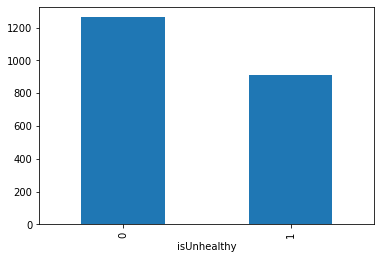

In [65]:
# GET OPENAQ DATAFRAME...
print(f"AQ Param Target: {selectedScenario.aqParamTarget.desc} (ShortName: {selectedScenario.aqParamTarget.name})")
print(f"Unhealthy Threshold: > {selectedScenario.unhealthyThreshold} {selectedScenario.aqParamTarget.unit}")
aq_df = selectedScenario.getOpenAqDataFrame()
    
# Output aq_df properties...
print('aq_df.shape =', aq_df.shape)
display(aq_df)
aq_df.groupby([mlTargetLabel]).size().plot(kind="bar")
aq_df.to_csv(selectedScenario.localDataOpenAQ, index=False)

In [66]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
merged_df = pd.merge(noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="day")
merged_df = merged_df.drop(columns=mlIgnoreColumns)
print('merged_df.shape =', merged_df.shape)
display(merged_df)
merged_df.to_csv(f'dataMERGED_{selectedScenario.name}_{selectedScenario.yearStart}-{selectedScenario.yearEnd}.csv', 
                 index=False)

# TODO: Explore other ways to join the data and handle null values...

merged_df.shape = (2170, 7)


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,isUnhealthy
0,53.8,3.9,66.9,55.9,0.25,3,1
1,52.2,0.9,77.0,53.1,0.00,3,0
2,53.0,2.1,77.0,52.0,0.00,3,0
3,43.7,1.8,69.1,46.9,0.52,3,0
4,47.2,2.3,68.0,46.9,0.00,3,0
...,...,...,...,...,...,...,...
2165,57.2,1.4,80.1,57.9,0.00,6,0
2166,56.7,1.6,79.0,60.1,0.00,6,0
2167,56.1,1.2,73.0,60.1,0.00,6,0
2168,56.0,1.5,73.9,60.1,0.00,6,0


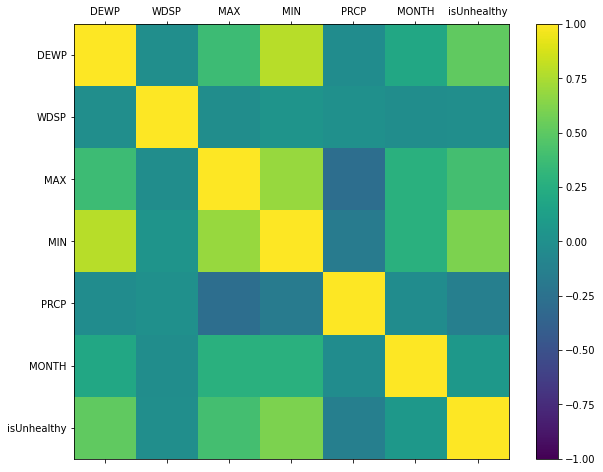

In [67]:
# Visualize correlations in our merged dataframe...
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

In [68]:
# Additional import statements for autogluon+sklearn and split our data...
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.33, random_state=1)
train_df.shape, validate_df.shape
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Number of training samples: 1453
Number of validation samples: 717


In [69]:
#Get test data and remove the target label column...
test_df=validate_df.drop([mlTargetLabel],axis=1)
display(test_df)

,DEWP,WDSP,MAX,MIN,PRCP,MONTH
951,50.2,0.8,66.9,46.9,0.00,1
2167,56.1,1.2,73.0,60.1,0.00,6
725,41.5,4.1,80.1,55.0,0.00,4
1751,38.9,1.0,86.0,48.9,0.00,3
1945,57.1,2.1,69.1,57.0,0.04,10
...,...,...,...,...,...,...
1908,56.1,1.3,75.9,61.0,0.00,9
531,60.0,1.2,77.0,63.0,0.00,9
1359,50.4,2.3,80.1,57.9,0.00,2
81,53.8,1.9,72.0,61.0,0.00,5


In [70]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
modelPath = f'AutogluonModels/aq_{selectedScenario.name}_{selectedScenario.yearStart}-{selectedScenario.yearEnd}/'
predictor = TabularPredictor(label=mlTargetLabel, eval_metric=mlEvalMetric, path=modelPath)
predictor.fit(train_data=train_df, time_limit=mlTimeLimitSecs, verbosity=2, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_los-angeles_o3_2016-2022/"
AutoGluon Version:  0.4.2
Python Version:     3.9.13
Operating System:   Linux
Train Data Rows:    1453
Train Data Columns: 6
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14563.03 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set f

In [51]:
# Get dataframes for feature correlation + leaderboard AND display model evaluation...
featureimp_df  = predictor.feature_importance(validate_df)
leaderboard_df = predictor.leaderboard(validate_df, silent=True)
display(predictor.evaluate(validate_df, auxiliary_metrics=False))

Computing feature importance via permutation shuffling for 7 features using 717 rows with 5 shuffle sets...
	69.17s	= Expected runtime (13.83s per shuffle set)
	17.68s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.8479776847977685
Evaluations on test data:
{
    "accuracy": 0.8479776847977685
}


{'accuracy': 0.8479776847977685}

In [52]:
# View (and/or plot) leaderboard...
display(leaderboard_df)
# leaderboard_df.plot(kind="bar", legend=False, figsize=(16, 4), x="model", y="score_val", xlabel="model", ylabel="score_val")

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L1,0.857741,0.843083,0.009818,0.079867,6.493232,0.009818,0.079867,6.493232,1,True,7
1,ExtraTreesGini_BAG_L1,0.847978,0.825189,0.139307,0.168905,0.805427,0.139307,0.168905,0.805427,1,True,8
2,WeightedEnsemble_L2,0.847978,0.850654,0.270334,0.191720,17.959275,0.002892,0.006937,1.129474,2,True,14
3,ExtraTreesGini_BAG_L2,0.847978,0.838954,1.395182,1.336947,68.419970,0.134752,0.155474,0.759492,2,True,20
4,WeightedEnsemble_L3,0.847978,0.860977,1.411535,1.309757,82.086349,0.002441,0.002657,1.001431,3,True,26
5,NeuralNetFastAI_BAG_L1,0.846583,0.849277,0.212693,0.113955,12.091425,0.212693,0.113955,12.091425,1,True,10
6,CatBoost_BAG_L2,0.846583,0.859601,1.275303,1.265861,79.530182,0.014873,0.084388,11.869704,2,True,19
7,XGBoost_BAG_L2,0.846583,0.860289,1.317641,1.240372,74.246002,0.057210,0.058898,6.585524,2,True,23
8,LightGBMXT_BAG_L1,0.845188,0.842395,0.049917,0.029538,5.840113,0.049917,0.029538,5.840113,1,True,3
9,LightGBMXT_BAG_L2,0.845188,0.854783,1.351884,1.248202,74.499393,0.091454,0.066728,6.838916,2,True,15


,importance,stddev,p_value,n,p99_high,p99_low
MONTH,0.131381,0.008449,0.000002,5,0.148778,0.113984
MIN,0.072524,0.010390,0.000049,5,0.093918,0.051131
DEWP,0.065830,0.016366,0.000423,5,0.099528,0.032132
MAX,0.022594,0.005868,0.000500,5,0.034676,0.010512
WDSP,0.005579,0.005124,0.035823,5,0.016130,-0.004973
PRCP,0.000837,0.001247,0.104000,5,0.003405,-0.001732
DAYOFWEEK,-0.000837,0.006732,0.602585,5,0.013025,-0.014699


<AxesSubplot:xlabel='feature'>

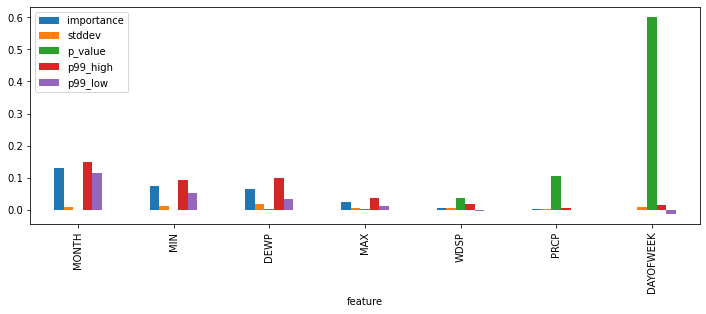

In [53]:
# View (and/or Plot) Leaderboard...
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

In [54]:
# Make Predictions...
y_pred = predictor.predict(test_df)
display(y_pred)

951     0
2167    1
725     0
1751    0
1945    0
       ..
1908    0
531     1
1359    0
81      1
969     0
Name: isUnhealthy, Length: 717, dtype: int64

In [55]:
# Get true label values...
y_true = validate_df[mlTargetLabel]
display(y_true)

951     0
2167    0
725     1
1751    1
1945    0
       ..
1908    0
531     1
1359    0
81      1
969     0
Name: isUnhealthy, Length: 717, dtype: int64

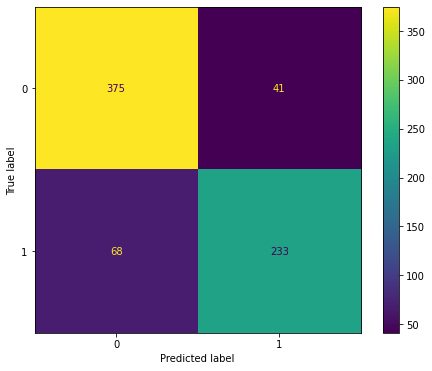

In [56]:
# View Confusion Matrix...
cm  = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

In [57]:
# Create and save final results...
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(f'dataRESULTS_{selectedScenario.name}_{selectedScenario.yearStart}-{selectedScenario.yearEnd}.csv', index=False)